In [45]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torchvision.transforms as tt
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import time

In [46]:
# Load the dataset
file_location = "datasets/CIFAR10"

train_dataset = CIFAR10(root=file_location, download=True, train=True, transform=tt.ToTensor())
test_dataset = CIFAR10(root=file_location, download=True, train=False, transform=tt.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [47]:
# Helper functions and class to load data and models to the GPU
def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)

In [48]:
batch_size = 100

# Dataloaders for the datasets
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)

device = get_device()
# Create data loaders for the GPU if available
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [49]:
# Function for calculating the accuracy
def accuracy(preds, labels):
    _, probs = torch.max(preds, dim=1)
    return torch.sum(probs == labels).item() / len(labels)


# Function for calculating the loss on a batch and a metric if one was given
def batch_loss(model, xb, yb, metric=None, transform=None):
    # Generate batch predictions
    if transform:
        xb = transform(xb)
    preds = model(xb) 
    metric_result = None
    # Calculate a metric if there is one
    if metric:
        metric_result = metric(preds,yb)
    # return Loss, metric and size
    return F.cross_entropy(preds,yb), metric_result, len(xb)


# Function to be used on the validation-test set
def evaluate(model, test_dl, metric=None, test_transform=None):
    # Generate predictions
    with torch.no_grad():
        results = [batch_loss(model,xb,yb,metric,test_transform) for xb,yb in test_dl]
        v_loss, v_metric, size = zip(*results)
    # return validation loss, validation accuracy and batch size
    return v_loss, v_metric, size

In [50]:
# Function to train a model, returns some statistics of the training
def fit(epochs, model, train_dl, test_dl, lr, wd, grad_clip=None, opt=None,
        train_transform=None, test_transform=None, verbose=False):
    # Define an optimizer if none was given
    if not opt:
        opt = torch.optim.Adam
    opt = opt(model.parameters(), lr=lr, weight_decay=wd)
    
    # Lists for some statistics
    train_loss = []
    valid_loss = []
    valid_accuracy = []
    
    for epoch in range(epochs):
        # Start training
        model.train()
        for xb,yb in train_dl:
            # Transform the data if needed
            loss,_,_ = batch_loss(model, xb, yb, transform=train_transform)
            # Calculate the gradients
            loss.backward()
            
            # Gradient clip
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            opt.step()
            opt.zero_grad()
            
        # Start evaluation
        v_loss, v_acc, size = evaluate(model,test_dl,accuracy,test_transform)
        total = np.sum(size)
        avg_v_loss = np.sum(np.multiply(v_loss,size))/total
        avg_v_acc = np.sum(np.multiply(v_acc,size))/total
        # Save statistics (train loss, avg loss and avg accuracy across batches)
        train_loss.append(loss)
        valid_loss.append(avg_v_loss)
        valid_accuracy.append(avg_v_acc)
        if verbose:
            print("Epoch [{}/{}], train_loss: {:.4f}, valid_loss: {:.4f}, valid_acc: {:.4f}"
                    .format(epoch+1, epochs, loss, avg_v_loss, avg_v_acc))
    
    # Return train loss, validation loss and validation accuracy per epoch
    return train_loss, valid_loss, valid_accuracy

In [51]:
# Function that plots the train loss, validation loss and validation accuracy
def show_stats(stats,name):
    fig, ax = plt.subplots(1,2,figsize=(15,6))
    fig.suptitle("Statistics for {}".format(name), fontsize=14)
    ax[0].plot(stats[name]["tL"], label="Train_loss", marker="o", markersize=4)
    ax[0].plot(stats[name]["vL"], label="Valid_loss", marker="^", markersize=4)
    ax[1].plot(stats[name]["vAcc"], label="Valid_accuracy")
    ax[0].legend()
    ax[1].legend()
    ax[0].set_xlabel("Epochs")
    ax[1].set_xlabel("Epochs")
    plt.show()

In [52]:
# Calculate the mean and the std of the channels for normalization
temp_dl = DataLoader(train_dataset, batch_size=len(train_dataset))
imgs, label = next(iter(temp_dl))
reds_mean = imgs[:,0,:,:].mean()
blues_mean = imgs[:,1,:,:].mean()
greens_mean = imgs[:,2,:,:].mean()
reds_std = imgs[:,0,:,:].std()
blues_std = imgs[:,1,:,:].std()
greens_std = imgs[:,2,:,:].std()

stats = ((reds_mean,blues_mean,greens_mean),(reds_std,blues_std,greens_std))
# Transformers for the dataset
train_transform = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode="reflect"),
                              tt.RandomHorizontalFlip(),
                              tt.Normalize(*stats)])
test_transform = tt.Compose([tt.Normalize(*stats)])

In [53]:
# Dictionary that will contain the performance of each model
# The format will be { "name of the model": {"training_loss": t_loss,
#                                            "valid_loss": v_loss,
#                                            "accuracy": acc
#                                            "parameters": par} }

models_statistics = {}
statistics = pd.DataFrame(columns=["Name","Train_Loss","Valid_Loss","Accuracy","Training_time","Comments"])

In [54]:
# Helper function to get the max n values out of an array
def avg_max(x,n):
    sorted_indices = np.argsort(x)
    sorted_arr = np.array(x)[sorted_indices]
    return np.mean(sorted_arr[-n:])

In [55]:
def save_stats(statistics,models_statistics,modelname, tL, vL, vAcc, trt, comment):
    statistics = statistics.append({"Name" : modelname, 
                                "Train_Loss" : tL[-1].item(),
                                "Valid_Loss" : vL[-1].item(),
                                "Accuracy" : avg_max(vAcc,3),
                                "Training_time" : trt,
                                "Comments" : comment
                               }, ignore_index=True)
    
    models_statistics[modelname] = {"tL": tL, "vL": vL, "vAcc": vAcc}
    
    return statistics.drop_duplicates()

In [56]:
# Helper function for convolutional block
def conv_2d(in_channels, out_channels, stride=1, ks=3, padding=1, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
              nn.ReLU(),
              nn.BatchNorm2d(out_channels)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

<h2>Residual convolutional neural network</h2>

In [57]:
class ResNet12(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_2d(in_channels, 64)
        self.conv2 = conv_2d(64, 128)
        self.res1 = nn.Sequential(conv_2d(128, 128), conv_2d(128, 128))
        self.res2 = nn.Sequential(conv_2d(128, 128), conv_2d(128, 128, stride=2))
        self.conv3 = conv_2d(128, 256, pool=True)
        self.res3 = nn.Sequential(conv_2d(256, 256), conv_2d(256, 256))
        self.res4 = nn.Sequential(conv_2d(256, 256), conv_2d(256, 256, stride=2))
        self.conv4 = conv_2d(256, 256, stride=2)
        self.final = nn.Sequential(nn.AdaptiveAvgPool2d(1),
                                   nn.Flatten(),
                                   nn.Linear(256,num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        # First residual group
        out = self.res1(out) + out
        out = self.res2(out) + out
        out = self.conv3(out)
        # Second residual group
        out = self.res3(out) + out
        out = self.res4(out) + out
        out = self.conv4(out)
        out = self.final(out)
        return out

In [58]:
res12 = to_device(ResNet12(3,10), device)

Epoch [1/15], train_loss: 1.1939, valid_loss: 1.1224, valid_acc: 0.5927
Epoch [2/15], train_loss: 0.8731, valid_loss: 0.8850, valid_acc: 0.6834
Epoch [3/15], train_loss: 0.6661, valid_loss: 0.6762, valid_acc: 0.7638
Epoch [4/15], train_loss: 0.5045, valid_loss: 0.5544, valid_acc: 0.8117
Epoch [5/15], train_loss: 0.6404, valid_loss: 0.4806, valid_acc: 0.8353
Epoch [6/15], train_loss: 0.3759, valid_loss: 0.4693, valid_acc: 0.8380
Epoch [7/15], train_loss: 0.5267, valid_loss: 0.4331, valid_acc: 0.8547
Epoch [8/15], train_loss: 0.5178, valid_loss: 0.3936, valid_acc: 0.8684
Epoch [9/15], train_loss: 0.4331, valid_loss: 0.3953, valid_acc: 0.8654
Epoch [10/15], train_loss: 0.2344, valid_loss: 0.3875, valid_acc: 0.8725
Epoch [11/15], train_loss: 0.3136, valid_loss: 0.3902, valid_acc: 0.8713
Epoch [12/15], train_loss: 0.2307, valid_loss: 0.3750, valid_acc: 0.8754
Epoch [13/15], train_loss: 0.3142, valid_loss: 0.3630, valid_acc: 0.8774
Epoch [14/15], train_loss: 0.2449, valid_loss: 0.3524, valid

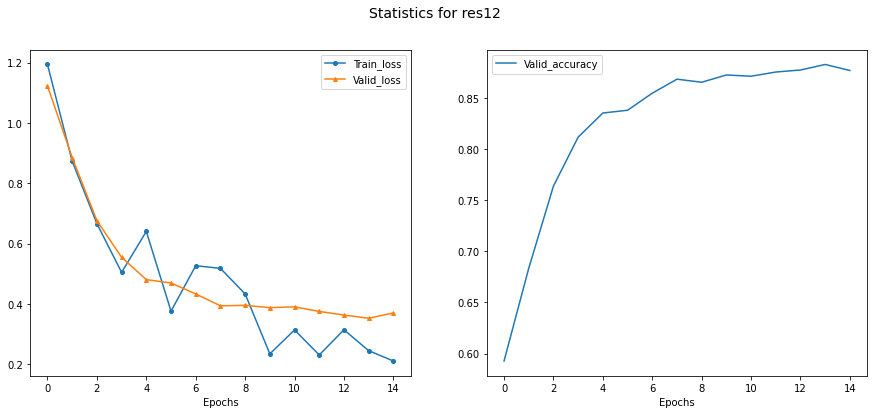

In [59]:
# Train model and get statistics
t1 = time.time()
tL, vL, vAcc = fit(15, res12, train_dl, 
                   test_dl, lr=0.001, wd=1e-4,
                   train_transform=train_transform, test_transform=test_transform,
                   verbose=True)
t2 = time.time() - t1
print("Res12 train time:", "{:.4f} seconds".format(t2))
# Save model statistics
statistics = save_stats(statistics,models_statistics,
                        "res12", tL, vL, vAcc, t2, 
                        "residual conv network with 4 residual units")

# Plot model statistics
show_stats(models_statistics, "res12")

In [61]:
import pickle
resnet_results = [statistics, models_statistics]
series = pickle.dumps(resnet_results)
with open("resnet_results.pkl", "wb") as file:
    pickle.dump(series, file)